# Tutorial 2: Human Tonsils (RNA + Protein Epitopes)

Welcome to this tutorial on using the `mTopic` package for spatial multimodal topic modeling of the human tonsil dataset.

This dataset provides the following key features:

- **Multimodal measurements**: Combines RNA and protein data, enabling integrated gene expression analysis and surface protein abundance analysis.
- **Spatial context**: Includes spatial coordinates for each cell or spot, allowing spatially informed analysis and visualization of tissue organization.

In this tutorial, we will walk through the following steps:

- Scaling and normalizing the data,
- Applying spatial multimodal topic modeling to identify distinct cell populations and explore their functional roles,
- Visualizing the results to gain insight into the spatial distribution of topics and cell types within the tissue.

Let us begin by importing the required libraries and downloading the filtered training data, available at [https://doi.org/10.5281/zenodo.15387482](https://doi.org/10.5281/zenodo.15387482).

In [1]:
import mtopic
import matplotlib

! wget -O Human_Tonsil_RNA_Protein_filtered.h5mu \
  "https://zenodo.org/records/15387482/files/Human_Tonsil_RNA_Protein_filtered.h5mu?download=1"

--2025-05-12 20:39:36--  https://zenodo.org/records/15387482/files/Human_Tonsil_RNA_Protein_filtered.h5mu?download=1
Resolving zenodo.org (zenodo.org)... 188.185.43.25, 188.185.45.92, 188.185.48.194, ...
Connecting to zenodo.org (zenodo.org)|188.185.43.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16108621 (15M) [application/octet-stream]
Saving to: ‘Human_Tonsil_RNA_Protein_filtered.h5mu’

Human_Tonsil_RNA_Pr 100%[===================>]  15.36M  34.2MB/s    in 0.4s    

2025-05-12 20:39:37 (34.2 MB/s) - ‘Human_Tonsil_RNA_Protein_filtered.h5mu’ saved [16108621/16108621]



## Spatial Multimodal Topic Modeling

Load the prefiltered `MuData` object containing the human tonsil dataset. This dataset includes 4,194 spatial spots and two modalities:

- `rna`: gene expression data,
- `prot`: protein abundance data.

In [2]:
ton = mtopic.read.h5mu('Human_Tonsil_RNA_Protein_filtered.h5mu')

ton

MuData object with n_obs × n_vars = 4194 × 5027
  obs:	'in_tissue'
  var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
  obsm:	'coords'
  2 modalities
    rna:	4194 x 5000
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
    prot:	4194 x 27
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'

Before training the spatial Multimodal Topic Model (`mtopic.tl.sMTM`), it is essential to preprocess the data to improve the model's ability to identify meaningful patterns across modalities.

To ensure comparability between RNA and protein data, we apply the following normalization and scaling steps:

- **TF-IDF transformation for RNA** (`mtopic.pp.tfidf`):  
  Adjusts raw gene expression counts by balancing feature frequency and importance, emphasizing rare but informative genes.

- **CLR normalization for protein** (`mtopic.pp.clr`):  
  Corrects compositional biases by normalizing protein counts across cells using the Centered Log Ratio method.

- **Scaling across modalities** (`mtopic.pp.scale_counts`):  
  Linearly scales counts to ensure all modalities contribute equally during topic modeling, preventing one from dominating the analysis.

In [3]:
mtopic.pp.tfidf(ton, mod='rna')
mtopic.pp.clr(ton, mod='prot')
mtopic.pp.scale_counts(ton)

Now that the data is preprocessed, we can train the spatial Multimodal Topic Model (`sMTM`). This model identifies coordinated patterns across modalities while incorporating spatial information. It captures co-expression of genes and proteins, revealing distinct cell populations and their functional states.

- **Initialize the model**:  
  Create an instance of the `mtopic.tl.MTM` class, specifying the number of topics (`n_topics`) and other parameters. We use 19 topics for this tutorial for a compact but expressive model.

- **Train the model**:  
  Fit the model using Variational Inference (`VI`). This iterative process updates the model parameters to explain the observed data best. While training time depends on dataset size, `sMTM` is optimized for scalability.

In [4]:
sMTM = mtopic.tl.sMTM(ton, n_topics=19, radius=0.02, n_jobs=100)
sMTM.VI(n_iter=20)

100%|███████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


After training, export the learned parameters to the `MuData` object using `mtopic.pp.export_params`:

- **Topic proportions** (`gamma`, saved as `ton.obsm['topics']`):  
  Represent the distribution of topics within each cell or spot. These proportions help identify which topics are active in different tissue regions.

- **Topic-feature distributions** (`lambda`, saved as `ton[modality].varm['signatures']`):  
  Indicate the importance of each feature (gene or protein) for each topic. These distributions help interpret the biological meaning of the topics.

In [5]:
mtopic.tl.export_params(sMTM, ton)

ton

MuData object with n_obs × n_vars = 4194 × 5027
  obs:	'in_tissue'
  var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
  obsm:	'coords', 'topics'
  2 modalities
    rna:	4194 x 5000
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
      varm:	'signatures'
    prot:	4194 x 27
      obs:	'n_counts'
      var:	'gene_ids', 'feature_types', 'genome', 'isotype_control', 'pattern', 'read', 'secondary_name', 'sequence', 'n_counts'
      varm:	'signatures'

The `mtopic.pp.export_params` function not only exports model parameters but can also filter out insignificant topics based on their overall contribution.

- **Topic filtering**:  
  Set `filter_topics=True` to automatically remove topics with low overall activity. The `filter_threshold` parameter controls the minimum average topic proportion required to retain a topic.

This helps remove spurious or noise-driven topics, simplifying downstream interpretation and visualization.

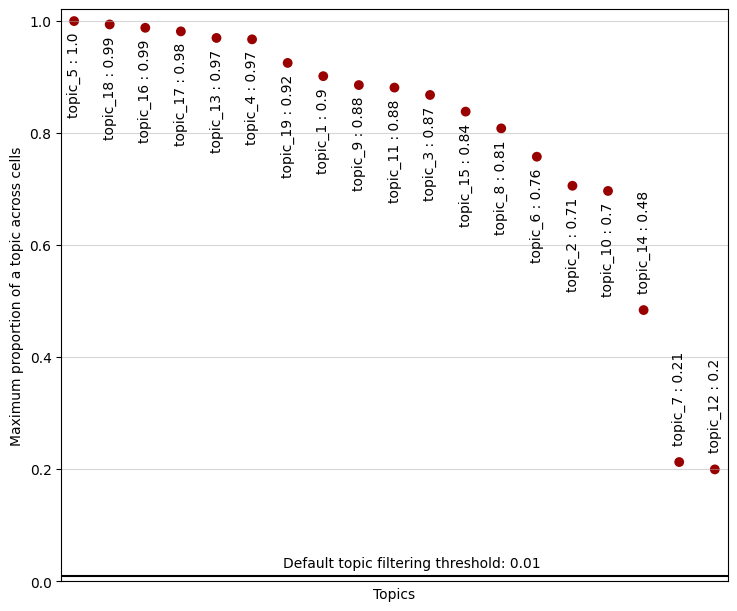

In [6]:
mtopic.pl.filter_topics(sMTM)

By preprocessing the data, training the `sMTM` model, and exporting the learned parameters, we have set the stage for a comprehensive analysis of cellular heterogeneity.

## Visualizing Topic Proportions

Visualizing topic distribution across cells or spatial spots is key in interpreting topic modeling results. These proportions reflect the contribution of each topic to each cell. They can reveal spatially organized cell states, types, or biological processes.

To visualize topic proportions, use the `mtopic.pl.topics` function to generate scatter plots where each cell or spot is colored according to the value of a selected topic. This reveals spatial patterns and gradients that help interpret biological variation within the tissue.

For example, if a topic captures a specific cell type, the plot will highlight regions enriched in that population.

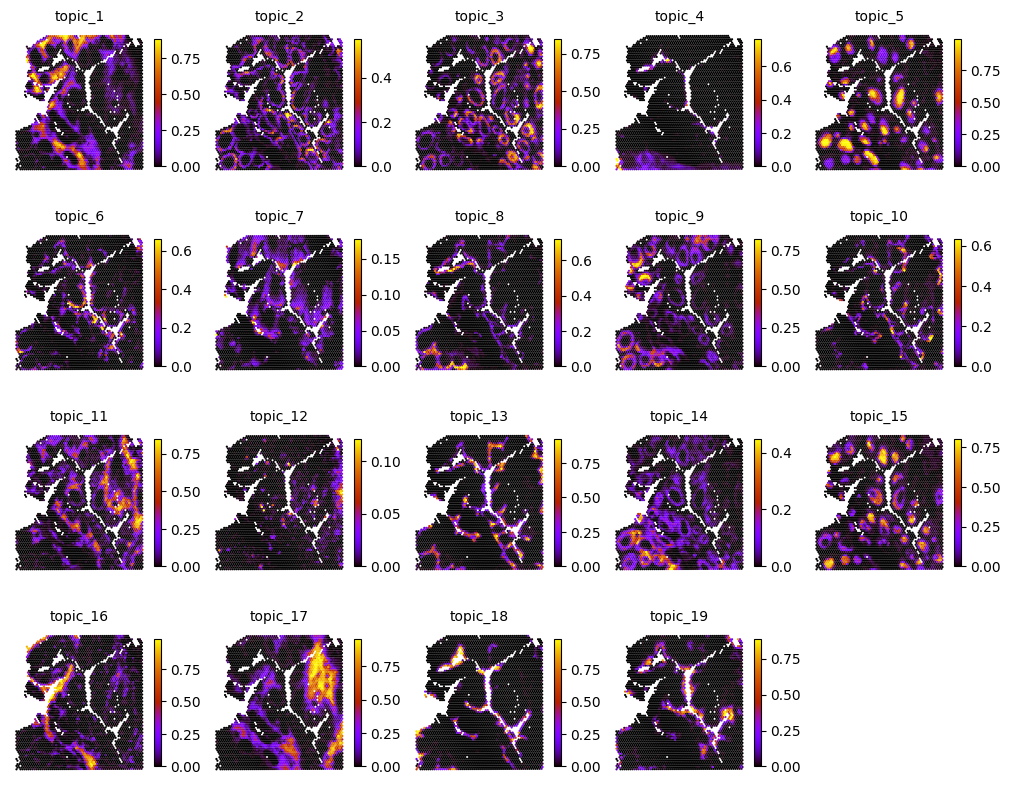

In [7]:
mtopic.pl.topics(ton, x='coords')

To visualize overall trends in topic distributions, use the `mtopic.pl.dominant_topics` function. This function assigns each cell or spot to its most dominant topic—the one with the highest proportion—and colors it accordingly.

The resulting plot provides a global overview of topic dominance across the tissue, helping you quickly identify regions enriched in specific topics. These regions may correspond to distinct cell types, tissue structures, or gradients of biological activity.

This visualization is handy for detecting the tissue's spatial domains and functional zones.

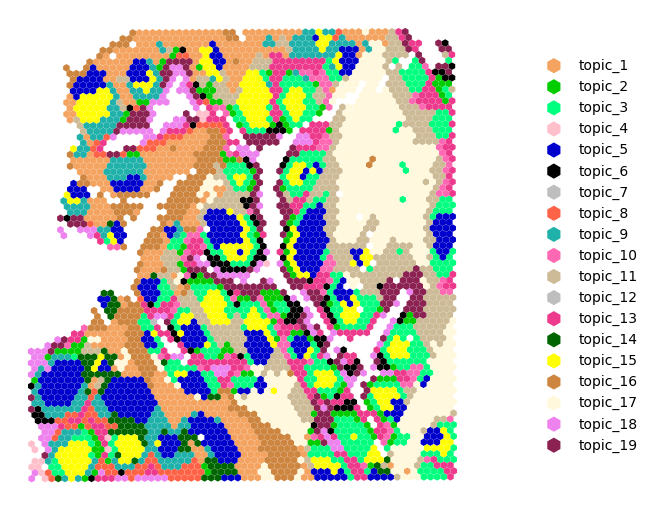

In [8]:
palette = {'topic_1': '#F4A460', 'topic_2': '#00CD00', 'topic_3': '#00FF7F',
           'topic_4': '#FFC0CB', 'topic_5': '#0000CD', 'topic_6': '#000000',
           'topic_7': '#BEBEBE', 'topic_8': '#FF6347', 'topic_9': '#20B2AA',
           'topic_10': '#FF69B4', 'topic_11': '#CDBA96', 'topic_12': '#BEBEBE',
           'topic_13': '#EE3A8C', 'topic_14': '#006400', 'topic_15': '#FFFF00',
           'topic_16': '#CD853F', 'topic_17': '#FFF8DC', 'topic_18': '#EE82EE',
           'topic_19': '#8B2252'}

mtopic.pl.dominant_topics(ton, x='coords', marker='h', s=30, palette=palette)

Alternatively, you can explore topic proportions in more detail using pie chart scatter plots with `mtopic.tl.scatter_pie`. This function visualizes the complete topic composition of each cell or spot as a pie chart.

Rendering may take time, especially for large datasets. To improve performance and focus on a specific region, you can limit the number of visualized spots using the `xrange` and `yrange` parameters (default: `[0, 1]`), which define the fraction of the spatial extent to display.

100%|█████████████████████████████████████████| 427/427 [00:08<00:00, 47.59it/s]


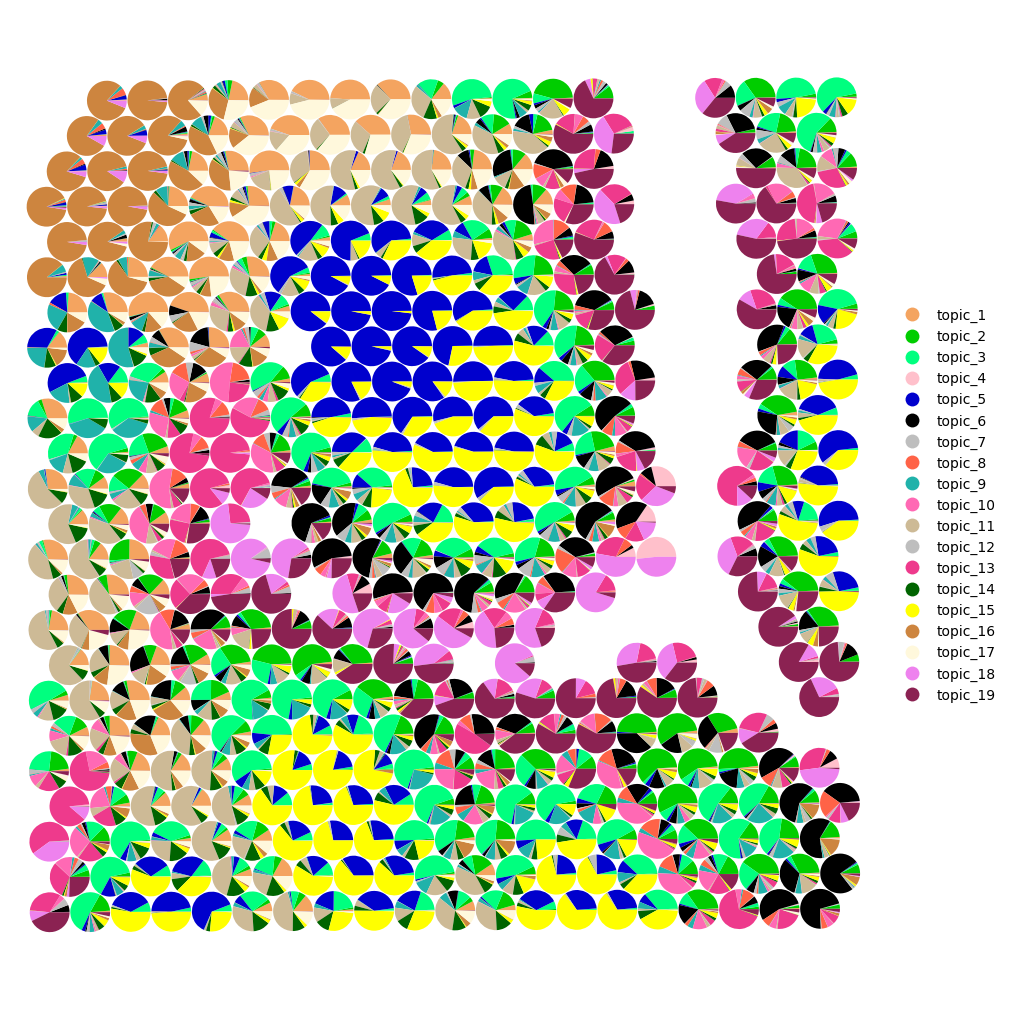

In [9]:
mtopic.pl.scatter_pie(ton, x='coords', radius=0.0073, palette=palette, xrange=[0.3, 0.6], yrange=[0.35, 0.65])

## Visualizing Feature Signatures

To interpret the results of the `sMTM` model, it is important to examine the feature signatures associated with each topic. Identifying the most relevant features—genes or proteins—for each topic provides insight into the biological identity and function of the inferred cell populations or processes.

Use the `mtopic.pl.signatures` function to visualize the top features per topic. This function generates a set of plots, each showing the most significant features ranked by their importance for a given topic.

These visualizations help reveal which molecular markers distinguish topics, aiding in biological interpretation and annotation of the results.

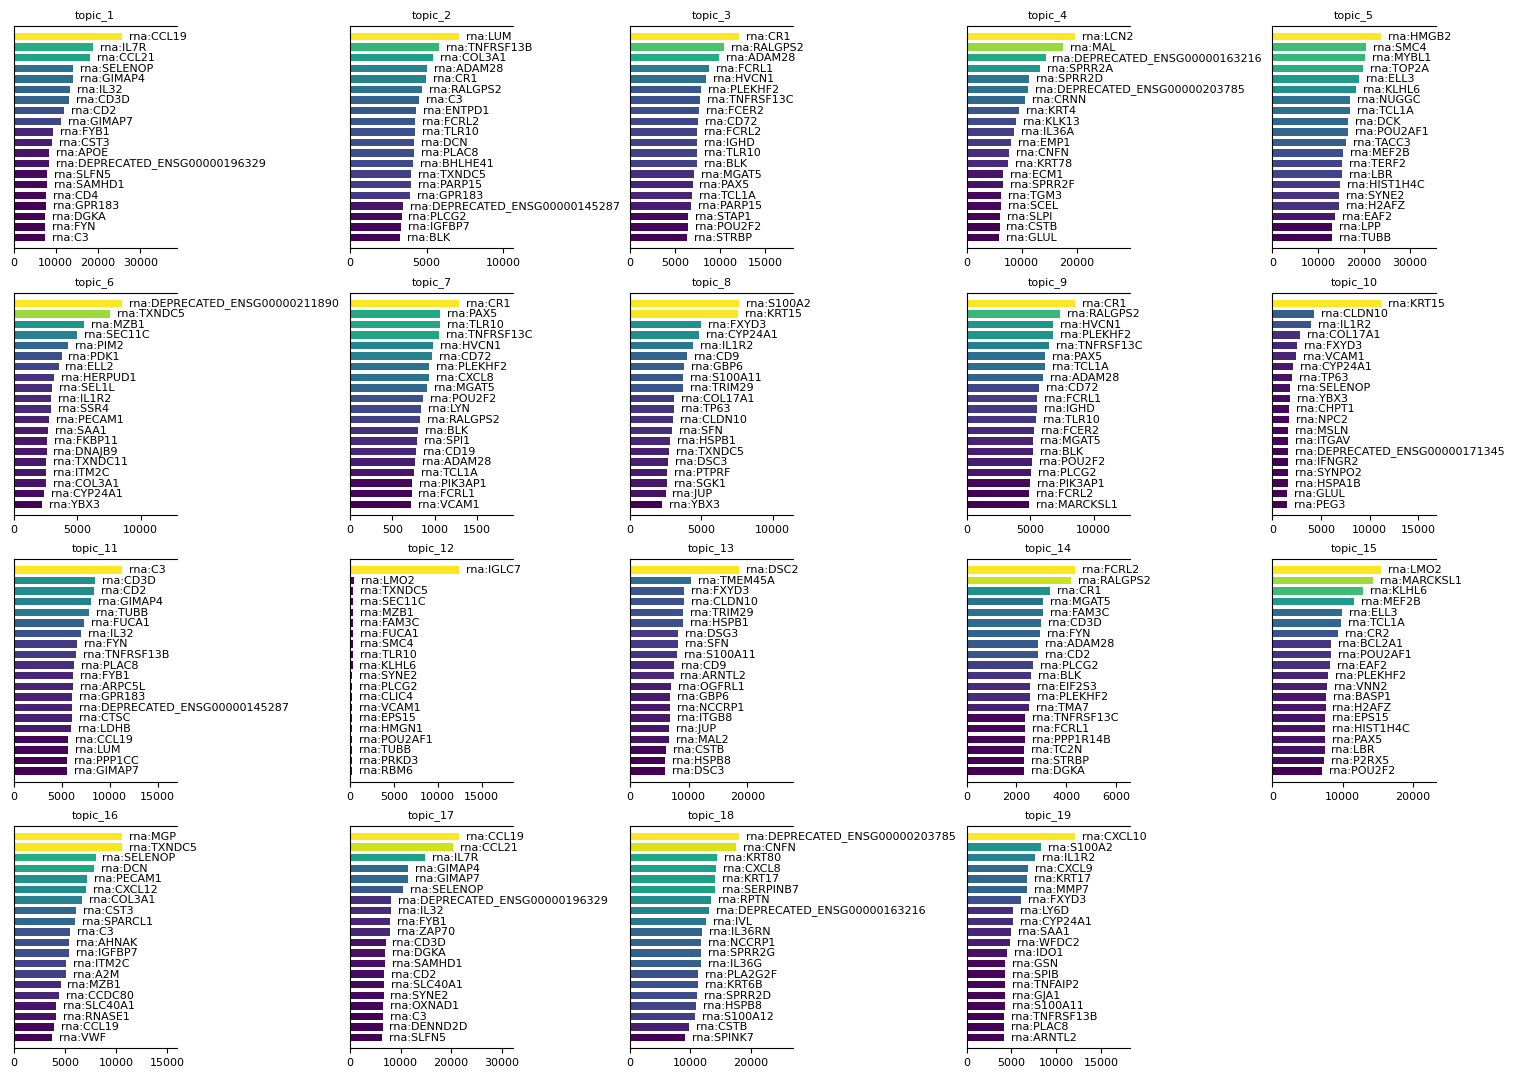

In [10]:
mtopic.pl.signatures(ton, mod='rna', n_top=20)

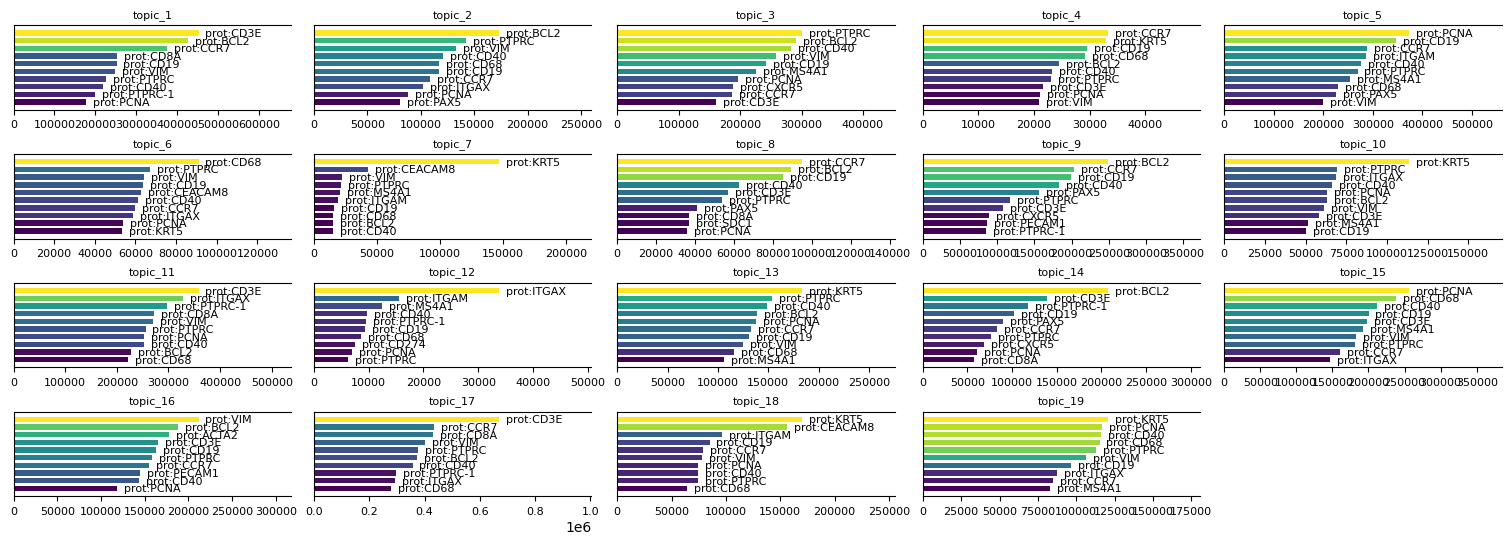

In [11]:
mtopic.pl.signatures(ton, mod='prot', n_top=10)

To better understand the spatial relevance of topic signatures and validate their biological specificity, you can visualize feature z-scores. A z-score indicates how much a feature’s expression in a given cell deviates from the mean, normalized by standard deviation. This highlights significantly up- or downregulated features in specific regions or cell populations.

Use `mtopic.tl.zscores` to compute modality-specific z-scores, and `mtopic.pl.zscores` to visualize their spatial distribution across the tissue. These plots help identify spatially localized or diffuse topics, revealing potential functional niches or gradients.

In the example below, we compute z-scores for the top 20 genes and top 3 proteins per topic to explore their spatial expression patterns.

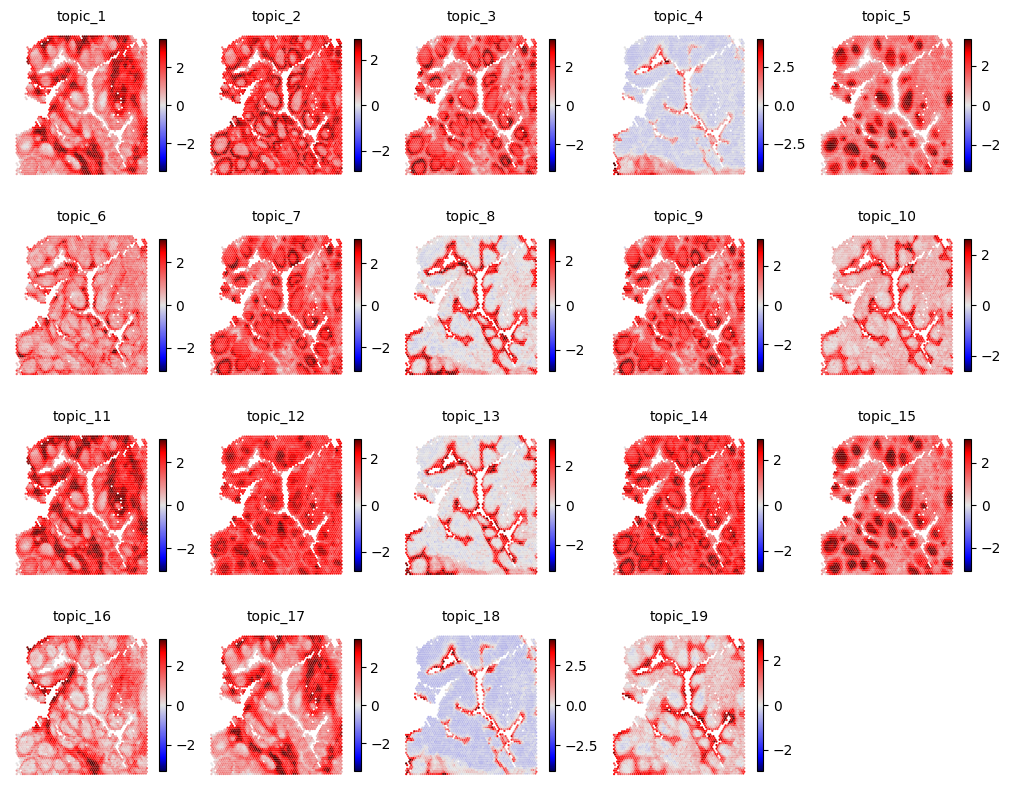

In [12]:
mtopic.tl.zscores(ton, raw_data_path='Human_Tonsil_RNA_Protein_filtered.h5mu', mod='rna', n_top=20)
mtopic.pl.zscores(ton, mod='rna', x='coords')

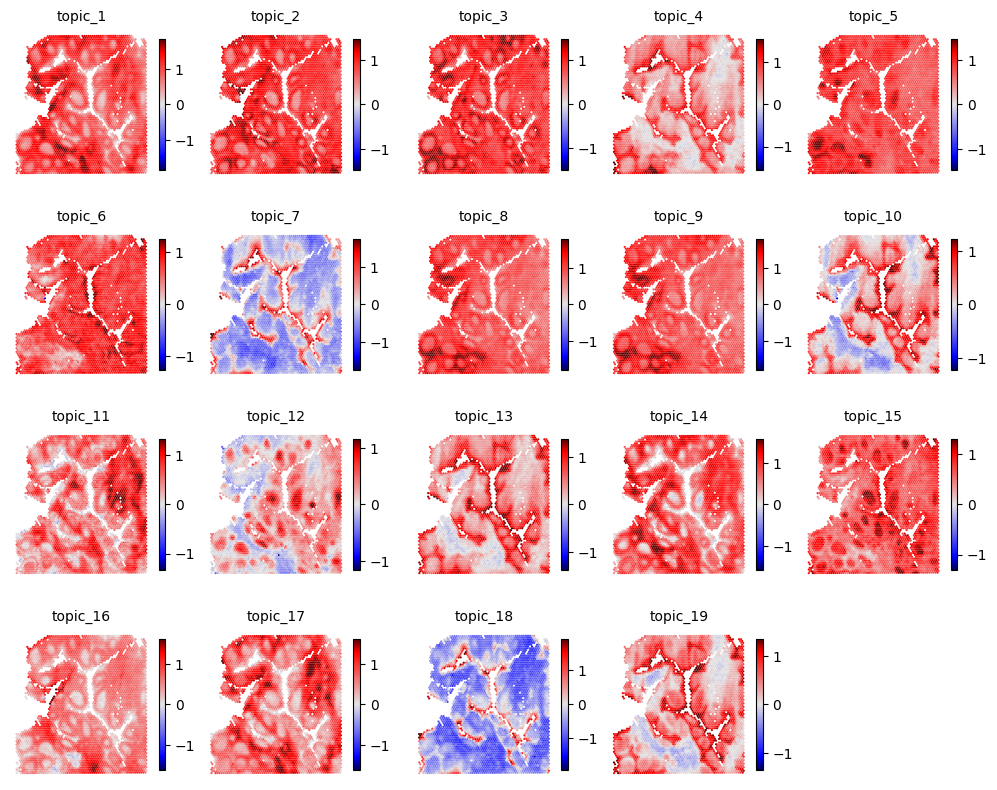

In [13]:
mtopic.tl.zscores(ton, raw_data_path='Human_Tonsil_RNA_Protein_filtered.h5mu', mod='prot', n_top=3)
mtopic.pl.zscores(ton, mod='prot', x='coords')

It is helpful to visualize the correlation between z-scores and topic proportions across cells to assess how well feature signatures align with inferred topic distributions.

Use the `mtopic.pl.corr_heatmap` function to generate a heatmap of correlations between z-scores (for top features) and topic proportions. Each cell in the heatmap represents the correlation strength for a feature-topic pair.

High values along the diagonal indicate that the selected features strongly correspond to their respective topics. This confirms that the topic model has captured biologically meaningful patterns.

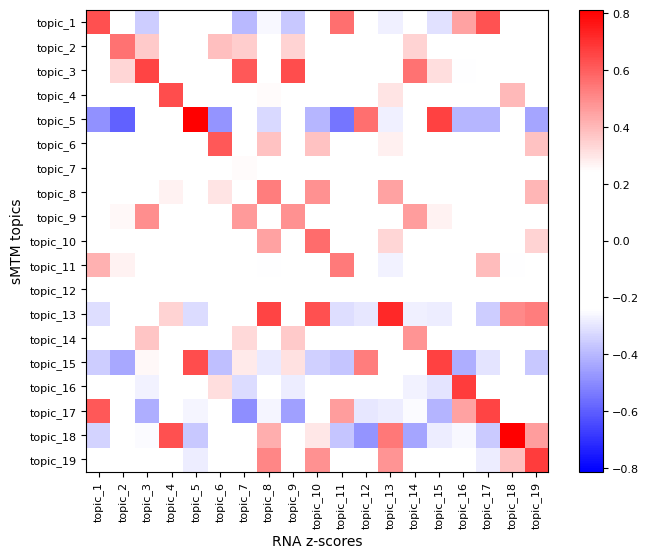

In [14]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom_gradient', [(0.0, "blue"), (0.35, "white"), (0.65, "white"), (1.0, "red")])

mtopic.pl.corr_heatmap(arr1=ton.obsm['topics'], label1='sMTM topics', arr2=ton['rna'].obsm['zscores'], label2='RNA z-scores', cmap=cmap)

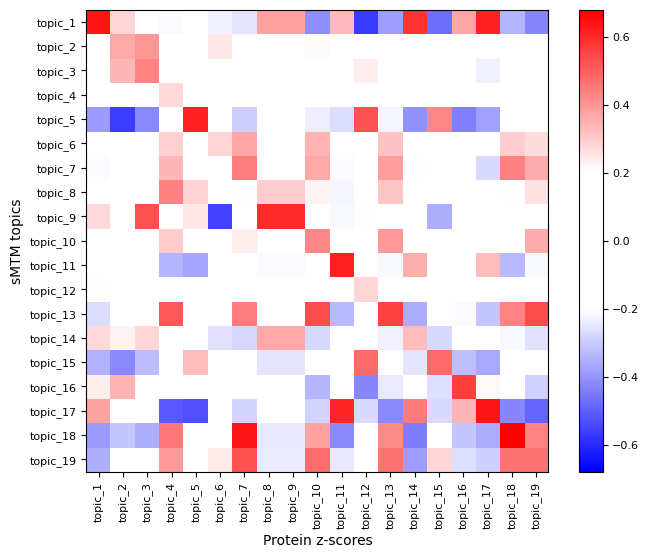

In [15]:
mtopic.pl.corr_heatmap(arr1=ton.obsm['topics'], label1='sMTM topics', arr2=ton['prot'].obsm['zscores'], label2='Protein z-scores', cmap=cmap)

This concludes the example application of `mTopic` for modeling spatial multimodal single-cell data, demonstrated using the human tonsil dataset. We have walked through preprocessing, topic modeling, and result interpretation—highlighting how `mTopic` enables integrated analysis across modalities with spatial context.

In [16]:
#ton.write('Human_Tonsil_RNA_Protein_trained.h5mu')